In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd 
import numpy as np


import matplotlib.pyplot as plt
import matplotlib as mpl

import sqlite3 as sqlite 
import math 

from src.dataprep.helpers.comparator_functions import text_comparator
from src.dataprep.helpers.variables import db_file


#### Overview
- Motivation
    - Because titles are short, we are not sure whether tfidf on the titles of scientific papers can detect links across authors
    - So we build a benchmark by comparing true and fake links between authors in MAG
- Approach
    - Sample authors within mag field 0 and their first papers stored in `author_info_linking`
    - Calculate true similarity
        - Randomly split paper titles in two, calculate maximum similarity between two papers in the two corpuses
    - Calculate fake similarity
        - For each author, draw one of their papers
        - Compare similarity to the paper titles of any of the other authors in the same population
    - Compare similiarities across the samples


Define functions

In [2]:
def extract_titles(s):
    s = s.split(";")
    l = [x.split("//")[1] for x in s]
    return l

def compare_random_split(rng, l):
    "Randomly split a list into 2 parts and apply text_comparator"
    if len(l) > 1:
        rint = rng.integers(low=1, high=len(l), size=1)[0]
        x = l[:rint]
        y = l[rint:]
        return text_comparator(x, y)
    else:
        return None

def query_db(db_file, field):
    query = f"""
        select authorid, year_papertitle
        from author_info_linking
        inner join (
            select authorid, fieldofstudyid
            from author_fields
            inner join (
                select fieldofstudyid
                from fieldsofstudy
                where normalizedname = "{field}"
            ) using(fieldofstudyid)
            where fieldclass = "main"
        ) using(authorid)
        inner join (
            select authorid
            from author_sample
            where yearfirstpub > 1990
                and yearlastpub < 2020
        ) using(authorid)
        where main_us_institutions_career is not NULL
        """

    con = sqlite.connect(db_file)
    with con:
        df = pd.read_sql(con=con, sql=query)

    con.close()
    return df


def records_sample_to_dict(df, random_state, sample_size):
    df["titles"] = df.apply(lambda row: extract_titles(row["year_papertitle"]), axis=1)
    df["n_titles"] = df.apply(lambda row: len(row["titles"]), axis=1)
    # take only first 5 papers -- the more there are, the more likely a high similarity by chance
    df["titles"] = df.apply(lambda row: row["titles"][:5], axis=1)

    dd = (df
            .loc[df["n_titles"] > 1, ["AuthorId", "titles"]]
            .sample(n=sample_size, random_state=random_state)
            .set_index("AuthorId")
            .to_dict("index"))
    dd = {k: v["titles"] for k, v in dd.items()}
    return dd

In [3]:


def compare_true(records, rng):
    "Compare title similarity for a sample of records"
    result = {
        k: compare_random_split(rng, v) for k, v in records.items()
    }
    df = pd.DataFrame.from_dict(result, orient="index")
    df = (df
            .rename(columns={0: "sim"})
            .reset_index()
            .rename(columns={"index": "AuthorId"})
            )
    df["link"] = "true_link"
    return df


In [4]:

def fake_similarity_one_record(sample, ref_id, rng):
    """
    create a fake pair of papers:
    - one doctitle from ref_id
    - all doctitles from a randomly drawn other record in sample

    Parameters:
    sample: a dictionary where keys identify authors and values are lists of doc titles by this author
    ref_id: reference author id
    rng: random number generator (integers)
    """
    set1 = sample[ref_id]
    # print(set1)
    if len(set1) > 1:
        draw_text1 = rng.integers(low=1, high=len(set1), size=1)[0]
        # print(draw_text1)
        text1 = [set1[draw_text1]]
    else:
        text1 = set1

    # print(text1)
    candidates = [x for x in sample.keys() if x != ref_id]
    draw_id2 = rng.integers(low=1, high=len(candidates), size=1)[0]
    # print(f"draw_set2 is {draw_id2}")
    id2 = candidates[draw_id2]
    # print(f"id2 is {id2}")
    set2 = sample[id2]
    # print(set2)

    return(text_comparator(set1, set2))


def compare_fake(records, rng):
    result = {
        k: fake_similarity_one_record(records, k, rng) for k in records.keys()
    }
    df = pd.DataFrame.from_dict(result, orient="index")
    df = (df
            .rename(columns={0: "sim"})
            .reset_index()
            .rename(columns={"index": "AuthorId"})
            )
    df["link"] = "fake_link"
    return df 



In [5]:
def benchmark_field(db_file, field, random_state=1, n=1000):
    """
    Benchmark the name comparator for field
    
    Parameters
    ----------
    db_file: file to database
    field: MAG field of study level 0
    random_state: input to np random number generator
    n: draw sample of n records from the population of researchers

    Details
    -------
    The population of researchers is defined as
    those with `field` as their main field ofstudy,
    that start their careers between 1990 and 2020,
    at least once work in the United States,
    and publish at least two papers.
    """
    rng = np.random.default_rng(random_state)

    df = query_db(db_file, field)
    sample = records_sample_to_dict(df, random_state=random_state, sample_size=n)
    similarity_true = compare_true(records=sample, rng=rng)
    similarity_fake = compare_fake(records=sample, rng=rng)

    results = [
        similarity_true,
        similarity_fake
    ]
    results = pd.concat(results)
    results["field"] = field

    return results




In [6]:

results = []
fields=["geology", "geography", "chemistry",
        "sociology", "mathematics",
        "biology", "computer science", "political science",
        "engineering", "psychology", "environmental science",
        "physics", "economics"]

n_authors = 1000

for f in fields:
    r = benchmark_field(db_file=db_file, field=f, random_state=2, n=n_authors)
    results.append(r)

results = pd.concat(results)

In [7]:
results.head()

,AuthorId,sim,link,field
0,2503703537,0.090597,true_link,geology
1,2144803850,0.056210,true_link,geology
2,2151828208,0.000000,true_link,geology
3,2116067800,0.123036,true_link,geology
4,2602164763,0.301137,true_link,geology


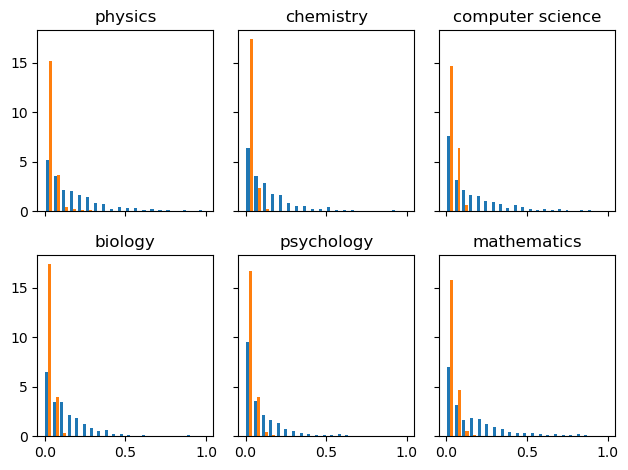

In [8]:


fields = ["physics", "chemistry", "computer science", "biology", "psychology", "mathematics"]
n_fields = len(fields)
n_rows = 2
n_cols = math.ceil(n_fields/n_rows)


fig, axs = plt.subplots(n_rows, n_cols, sharey=True, sharex=True,  tight_layout=True)
nbins = 20

row = 0
col = 0
with mpl.rc_context({"lines.linewidth": 1}):
    for i in range(n_fields):
        #print(f"(col, row) are ({col}, {row})")
        f = fields[i]
        data = results.loc[results["field"] == f, :]
        groups = data["link"].unique()
        x = [data.loc[data["link"] == g, "sim"] for g in groups]
        medians = [np.median(i) for i in x]
        axs[row, col].hist(x, bins=nbins, label=groups, density=True)
        axs[row, col].title.set_text(f)
        #axs[row, col].vlines(x=medians, ymin=0, ymax=20, linestyles="dashed", label=groups)
        # update col, row for next plot
        col += 1
        if col >= n_cols:
            row += 1
            col = 0


plt.show()



In [9]:
results.head()

aggstat = (results
            .groupby(["field", "link"])
            .agg(mean=("sim", np.mean),
                 median=("sim", np.median),
                 sd=("sim", np.std)
                 )
            .reset_index()
            .melt(
               id_vars=["field", "link"],
               value_vars=["mean", "median", "sd"]
            )
            )

aggstat.head()

,field,link,variable,value
0,biology,fake_link,mean,0.026346
1,biology,true_link,mean,0.140574
2,chemistry,fake_link,mean,0.023841
3,chemistry,true_link,mean,0.155825
4,computer science,fake_link,mean,0.030321


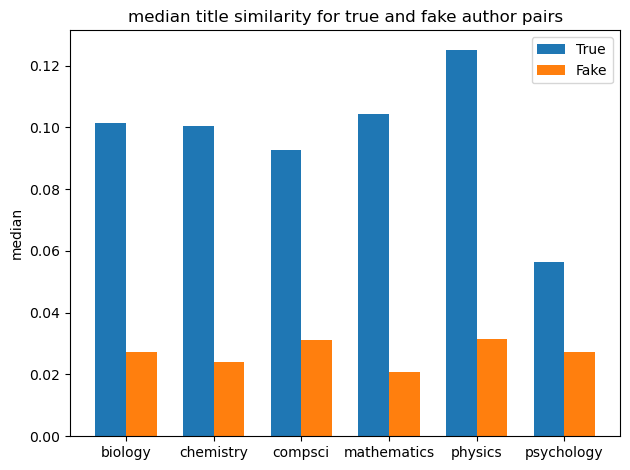

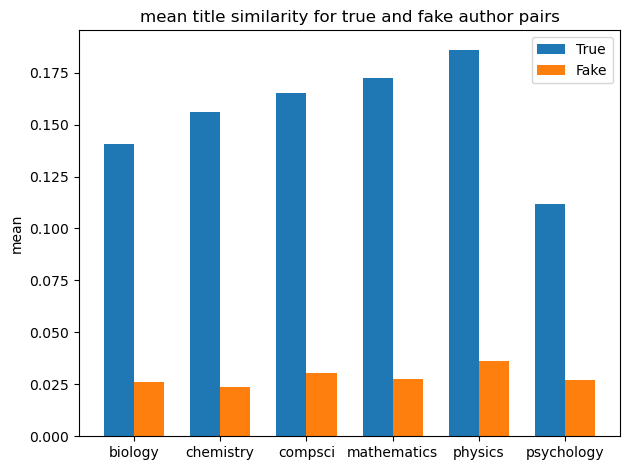

In [10]:

fields = ["physics", "chemistry", "computer science", "biology", "psychology", "mathematics"]
#fields = ["sociology", "economics", "psychology", "political science"] # seems to do worse on social sciences

keep_stats = ["median", "mean"]

for stat in keep_stats:
        mask = (aggstat.variable == stat) \
                & (aggstat.field.isin(fields))

        d = aggstat.loc[mask, :].copy()
        d["field"] = np.where(d["field"] == "computer science", "compsci", d.loc[:, "field"])

        true_means = list(d.loc[d.link == "true_link", "value"])
        fake_means = list(d.loc[d.link == "fake_link", "value"])
        labels = list(d.field.unique())

        x = np.arange(len(labels)) # the label locations
        width = 0.35

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, true_means, width, label='True')
        rects2 = ax.bar(x + width/2, fake_means, width, label='Fake')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(stat)
        ax.set_title(f'{stat} title similarity for true and fake author pairs')
        ax.set_xticks(x, labels)
        ax.legend()
        
        fig.tight_layout()      

        plt.show()


In [11]:
mask = (aggstat["link"] == "true_link") & (aggstat["variable"] == "sd")
aggstat.loc[mask, "value"].describe()

count    13.000000
mean      0.164677
std       0.023518
min       0.126357
25%       0.146577
50%       0.152290
75%       0.192390
max       0.196659
Name: value, dtype: float64

Comments
- There is a lot of noise in the true sample 
    - How can we increase precision?
    - Can we reduce the mean in the fake sample by adding more stop words?
- How representative is this of the problem of theses to publications?
    - we only use few papers from beginning; and authors may be working on two topics that do not have many words in common


In [12]:

from src.dataprep.helpers.comparator_functions import stemmed_words

doc = "progesterone receptor isoforms a and b temporal and spatial differences in expression during murine mammary gland development"
stemmed_words(doc)


# stem_vectorizer = CountVectorizer(analyzer=stemmed_words)
# print(stem_vectorizer.fit_transform(['automorphisms of the nottingham group']))
# print(stem_vectorizer.get_feature_names())


Vectorizer = TfidfVectorizer(
    analyzer=stemmed_words
    )
corpus = ["progesterone receptor isoforms a and b temporal and spatial differences in expression during murine mammary gland development",
            "progestins and breast cancer", 
            "differential hormonal regulation and function of progesterone receptor isoforms in normal adult mouse mammary gland",
            "progesterone receptor isoforms and proliferation in the rat mammary gland during development",
            "progesterone receptor isoform functions in normal breast development and breast cancer"]


tfidf = Vectorizer.fit_transform(corpus)
pairwise_similarity = tfidf * tfidf.T
similarity = pairwise_similarity.toarray()
print(corpus)
print(similarity)

Vectorizer = TfidfVectorizer()
tfidf = Vectorizer.fit_transform(corpus)
pairwise_similarity = tfidf * tfidf.T
similarity = pairwise_similarity.toarray()
print(similarity)

['progesterone receptor isoforms a and b temporal and spatial differences in expression during murine mammary gland development', 'progestins and breast cancer', 'differential hormonal regulation and function of progesterone receptor isoforms in normal adult mouse mammary gland', 'progesterone receptor isoforms and proliferation in the rat mammary gland during development', 'progesterone receptor isoform functions in normal breast development and breast cancer']
[[1.         0.         0.17116456 0.29414288 0.14096145]
 [0.         1.         0.         0.         0.374278  ]
 [0.17116456 0.         1.         0.21267662 0.19887646]
 [0.29414288 0.         0.21267662 1.         0.17514844]
 [0.14096145 0.374278   0.19887646 0.17514844 1.        ]]
[[1.         0.09361234 0.28279756 0.4905356  0.22153608]
 [0.09361234 1.         0.04475981 0.05547573 0.4994145 ]
 [0.28279756 0.04475981 1.         0.30752228 0.20903453]
 [0.4905356  0.05547573 0.30752228 1.         0.2304273 ]
 [0.221536

In [5]:

a = ['sliding toward the free market shifting political coalitions and u s agricultural policy 1945 1975']
b = ['welcome to the free market class bases of united states agricultural policy 1938 1996']
text_comparator(a, b)

0.1683975003721528